In [1]:
import os
import sys
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import pandas as pd
import json

In [2]:
conf = pd.read_csv('./csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
conf = conf.sort_values(conf.columns[-1], ascending=False)
conf.head(10)

Province/State Country/Region        Lat        Long  1/22/20  1/23/20  \
242            NaN             US  40.000000 -100.000000        1        1   
30             NaN         Brazil -14.235000  -51.925300        0        0   
143            NaN          India  20.593684   78.962880        0        0   
208            NaN         Russia  61.524010  105.318756        0        0   
224            NaN   South Africa -30.559500   22.937500        0        0   
177            NaN         Mexico  23.634500 -102.552800        0        0   
202            NaN           Peru  -9.190000  -75.015200        0        0   
89             NaN       Colombia   4.570900  -74.297300        0        0   
55             NaN          Chile -35.675100  -71.543000        0        0   
226            NaN          Spain  40.463667   -3.749220        0        0   

     1/24/20  1/25/20  1/26/20  1/27/20  ...   8/6/20   8/7/20   8/8/20  \
242        2        2        5        5  ...  4883582  4941755  4997929   
30         0        0        0        0  ...  2912212  2962442  3012412   
143        0        0        0        0  ...  2027074  2088611  2153010   
208        0        0        0        0  ...   870187   875378   880563   
224        0        0        0        0  ...   538184   545476   553188   
177        0        0        0        0  ...   462690   469407   475902   
202        0        0        0        0  ...   455409   463875   463875   
89         0        0        0        0  ...   357710   367204   376870   
55         0        0        0        0  ...   366671   368825   371023   
226        0        0        0        0  ...   309855   314362   314362   

      8/9/20  8/10/20  8/11/20  8/12/20  8/13/20  8/14/20  8/15/20  
242  5044864  5094400  5141208  5197411  5248958  5313252  5361165  
30   3035422  3057470  3109630  3164785  3224876  3226443  3317096  
143  2215074  2268675  2329638  2396637  2461190  2525922  2589952  
208   885718   890799   895691   900745   905762   910778   915808  
224   559859   563598   566109   568919   572865   579140   583653  
177   480278   485836   492522   498380   505751   511369   517714  
202   478024   483133   489680   489680   498555   516296   516296  
89    387481   397623   410453   422519   433805   445111   456689  
55    373056   375044   376616   378168   380034   382111   383902  
226   314362   322980   326612   329784   337334   342813   342813  

[10 rows x 211 columns]

In [3]:
for c in list(conf['Country/Region'].unique()):
    print(c)

US
Brazil
India
Russia
South Africa
Mexico
Peru
Colombia
Chile
Spain
Iran
United Kingdom
Saudi Arabia
Argentina
Pakistan
Bangladesh
Italy
Turkey
France
Germany
Iraq
Philippines
Indonesia
Qatar
Kazakhstan
Ecuador
Bolivia
Egypt
Israel
Ukraine
Dominican Republic
Sweden
Oman
Panama
Belgium
Kuwait
Romania
Belarus
China
United Arab Emirates
Netherlands
Guatemala
Canada
Poland
Singapore
Japan
Portugal
Honduras
Nigeria
Bahrain
Ghana
Kyrgyzstan
Armenia
Morocco
Algeria
Switzerland
Afghanistan
Uzbekistan
Azerbaijan
Venezuela
Moldova
Kenya
Serbia
Ethiopia
Costa Rica
Ireland
Nepal
Austria
El Salvador
Czechia
Cameroon
Cote d'Ivoire
Australia
West Bank and Gaza
Bosnia and Herzegovina
Denmark
Korea, South
Bulgaria
Madagascar
North Macedonia
Sudan
Senegal
Kosovo
Norway
Congo (Kinshasa)
Paraguay
Zambia
Malaysia
Lebanon
Guinea
Gabon
Tajikistan
Haiti
Libya
Finland
Luxembourg
Albania
Greece
Mauritania
Croatia
Maldives
Djibouti
Zimbabwe
Malawi
Hungary
Equatorial Guinea
Central African Republic
Nicaragua
Mon

In [4]:
# Combine rows that correspond to the same country but different state/province

conf = pd.read_csv('./csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
conf = conf.sort_values(conf.columns[-1], ascending=False)
conf.drop(columns=['Province/State'], inplace=True)
cols = list(conf.columns.values)
vals = []
dates = []
for col in cols:
    if col[0].isdigit():
        dates.append(col)
        vals.append('sum')
    else:
        vals.append('first')
agg = dict(zip(cols, vals))
conf_combined = conf.groupby(conf['Country/Region']).aggregate(agg)
conf_combined = conf_combined.sort_values(conf_combined.columns[-1], ascending=False)

In [5]:
deaths = pd.read_csv('./csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
deaths = deaths.sort_values(conf.columns[-1], ascending=False)
deaths.drop(columns=['Province/State'], inplace=True)
cols = list(deaths.columns.values)
vals = []
dates = []
for col in cols:
    if col[0].isdigit():
        dates.append(col)
        vals.append('sum')
    else:
        vals.append('first')
agg = dict(zip(cols, vals))
death_combined = deaths.groupby(conf['Country/Region']).aggregate(agg)
#death_combined = death_combined.sort_values(conf_combined.columns[-1], ascending=False)
death_combined = death_combined.reindex(conf_combined.index)

In [6]:
test = conf_combined.drop(['Country/Region', 'Lat', 'Long'], axis=1)
test.index
test.iloc[0,:]

1/22/20          1
1/23/20          1
1/24/20          2
1/25/20          2
1/26/20          5
            ...   
8/11/20    5141208
8/12/20    5197411
8/13/20    5248958
8/14/20    5313252
8/15/20    5361165
Name: US, Length: 207, dtype: int64

In [7]:
"""Normalized growth rate

Parameters
----------
arr : float
    1D array of data
dx : float
    spacing beween data points
padding : string
    type of padding for boundaries
    Options: 'Same', 'Zero', 'Reflect
    
Returns 
-------
float
    1D array of growth rates'"""
def growth(arr, dx, padding='Same'):
    d = [None] * len(arr)
    for i in range(1, len(arr)-1):
        d[i] = (arr[i] - arr[i-1]) / dx
    if padding is 'Same':
        d[0] = d[1]
        d[-1] = d[-2]
    elif padding is 'Zero':
        d[0] = 0
        d[-1] = 0
    elif padding is 'Reflect':
        d[0] = d[-1]
        d[-1] = d[0]
    return d

"""2nd derivative finite difference (https://en.wikipedia.org/wiki/Five-point_stencil)

Parameters
----------
arr : float
    1D array of data
dx : float
    spacing between data points (must be constant)
padding : string
    type of padding for boundaries
    Options: 'Same', 'Zero', 'Reflect'
stencil_size : int
    size of stencil
    Option: 3, 5
    
Returns
-------
float
    1D array of finite differences
"""
def fd_2(arr, dx, padding='Same', stencil_size=3):
    d = [None] * len(arr)
    if stencil_size is 3:
        for i in range(1, len(arr)-1):
            d[i] = (arr[i-1] - 2*arr[i] + arr[i+1]) / dx
    elif stencil_size is 5:
        d[1] = (arr[0] - 2*arr[1] + arr[2]) / dx
        d[-2] = (arr[-3] - 2*arr[-2] + arr[-1]) / dx
        for i in range(2, len(arr) - 2):
            d[i] = (-arr[i-2] + 16*arr[i-1] - 30*arr[i] + 16*arr[i+1] - arr[i+2]) / 12

    if padding is 'Same':
        d[0] = d[1]
        d[-1] = d[-2]
    elif padding is 'Zero':
        d[0] = 0
        d[-1] = 0
    elif padding is 'Reflect':
        d[0] = d[-1]
        d[-1] = d[0]
    return d

In [80]:
from scipy.ndimage import gaussian_filter1d as gauss

def plotn(dates, df, filter_strength=1, num_countries=1, title='Untitled', date_range=[0,-1], mode='num_cases'):
    plt.figure()
    df_T = df.T
    x = [dt.datetime.strptime(d, '%m/%d/%y').date() for d in dates]
    legend = df['Country/Region']
    dr = date_range
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%y'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=20))
    if mode is 'num_cases':
        for i in range(num_countries):
            y = gauss(list(df_T.drop(['Country/Region', 'Lat', 'Long'], axis=0).iloc[dr[0]:dr[1],i]), filter_strength)
            plt.plot(x[dr[0]:dr[1]], y, label=legend[i])
#             plt.plot(x[dr[0]:dr[1]], df_T.drop(['Country/Region', 'Lat', 'Long'], axis=0).iloc[dr[0]:dr[1],i], label=legend[i])
    elif mode is 'growth':
        for i in range(num_countries):
            g = growth(list(df_T.drop(['Country/Region', 'Lat', 'Long'], axis=0).iloc[:,i]), 1, 'Same')
            g = gauss(g, filter_strength)
            plt.plot(x[dr[0]:dr[1]], g[dr[0]:dr[1]], label=legend[i])
    elif mode is 'deriv2':
        for i in range(num_countries):
            d = fd_2(list(df_T.drop(['Country/Region', 'Lat', 'Long'], axis=0).iloc[:,i]), 1, 'Same')
            plt.plot(x[dr[0]:dr[1]], d[dr[0]:dr[1]], label=legend[i])
    plt.legend(loc='lower right', bbox_to_anchor=(1.4,0))
    plt.title(title)
    plt.gcf().autofmt_xdate()
    return plt
    
def plotc(dates, df, filter_strength=1, countries=['US'], title='Untitled', date_range=[0,-1], mode='num_cases'):
    plt.figure()
    df_T = df.T
    x = [dt.datetime.strptime(d, '%m/%d/%y').date() for d in dates]
    dr = date_range
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%y'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=20))
    if mode is 'num_cases':
        for c in countries:
            y = gauss(list(df_T.drop(['Country/Region', 'Lat', 'Long'], axis=0)[c]), filter_strength)
            plt.plot(x[dr[0]:dr[1]], y[dr[0]:dr[1]], label=c)
    elif mode is 'growth':
        for c in countries:
            g = growth(list(df_T.drop(['Country/Region', 'Lat', 'Long'], axis=0)[c]), 1, 'Same')
            g = gauss(g, filter_strength)
            plt.plot(x[dr[0]:dr[1]], g[dr[0]:dr[1]], label=c)
    elif mode is 'deriv2':
        for c in countries:
            d = fd_2(list(df_T.drop(['Country/Region', 'Lat', 'Long'], axis=0)[c]), 1, 'Same', 3)
            plt.plot(x[dr[0]:dr[1]], d[dr[0]:dr[1]], label=c)
    plt.legend(loc='lower right', bbox_to_anchor=(1.4,0))
    plt.title(title)
    plt.gcf().autofmt_xdate()
    return plt

In [33]:
def create_json(df_orig, title, delta_x=1):
    df = df_orig.drop(['Country/Region', 'Lat', 'Long'], axis=1)
    df_temp = df.copy()
    
    j_num_cases = df.to_json(orient='index')
    for i in range(len(df.index)):
        df_temp.iloc[i,:] = growth(list(df.iloc[i,:]), delta_x, 'Same')
    j_growth = df_temp.to_json(orient='index')
    for i in range(len(df.index)):
        df_temp.iloc[i,:] = fd_2(list(df.iloc[i,:]), delta_x, 'Same', 3)
    j_deriv2 = df_temp.to_json(orient='index')
    
    with open('{}_num_cases.json'.format(title), 'w') as f:
        json.dump(j_num_cases, f)
    with open('{}_growth.json'.format(title), 'w') as f:
        json.dump(j_growth, f)
    with open('{}_deriv2.json'.format(title), 'w') as f:
        json.dump(j_deriv2, f)

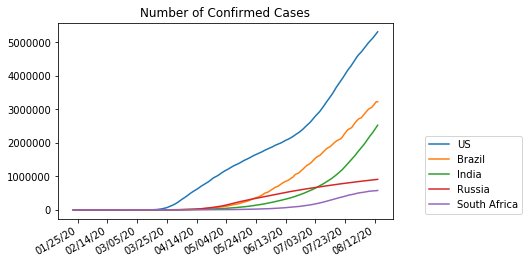

In [84]:
plt = plotn(dates, conf_combined, 0.1, 5, mode='num_cases', title='Number of Confirmed Cases')

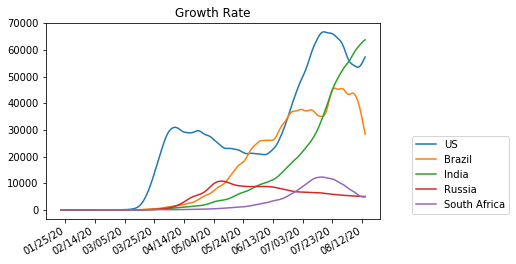

In [85]:
plt = plotn(dates, conf_combined, 3, 5, title='Growth Rate', mode='growth')

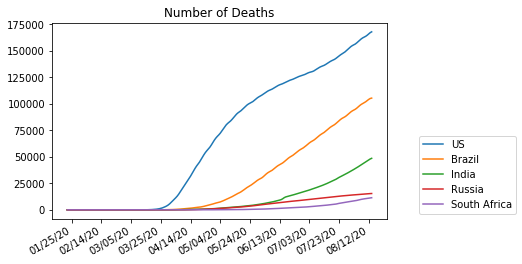

In [86]:
plt = plotn(dates, death_combined, 1, 5, mode='num_cases', title='Number of Deaths')

In [14]:
mort = death_combined.copy()
mort.iloc[:,3:] = (mort.iloc[:,3:]/conf_combined.iloc[:,3:]).replace([np.inf, np.nan], 0)
mort.head()

Country/Region        Lat        Long  1/22/20  1/23/20  \
Country/Region                                                           
US                         US  40.000000 -100.000000      0.0      0.0   
Brazil                 Brazil -14.235000  -51.925300      0.0      0.0   
India                   India  20.593684   78.962880      0.0      0.0   
Russia                 Russia  61.524010  105.318756      0.0      0.0   
South Africa     South Africa -30.559500   22.937500      0.0      0.0   

                1/24/20  1/25/20  1/26/20  1/27/20  1/28/20  ...    8/6/20  \
Country/Region                                               ...             
US                  0.0      0.0      0.0      0.0      0.0  ...  0.032784   
Brazil              0.0      0.0      0.0      0.0      0.0  ...  0.033821   
India               0.0      0.0      0.0      0.0      0.0  ...  0.020515   
Russia              0.0      0.0      0.0      0.0      0.0  ...  0.016754   
South Africa        0.0      0.0      0.0      0.0      0.0  ...  0.017845   

                  8/7/20    8/8/20    8/9/20   8/10/20   8/11/20   8/12/20  \
Country/Region                                                               
US              0.032650  0.032498  0.032298  0.032087  0.032002  0.031946   
Brazil          0.033611  0.033354  0.033290  0.033280  0.033131  0.032925   
India           0.020357  0.020148  0.020038  0.019949  0.019785  0.019625   
Russia          0.016790  0.016838  0.016826  0.016809  0.016862  0.016909   
South Africa    0.018166  0.018457  0.018590  0.018845  0.018991  0.019352   

                 8/13/20   8/14/20   8/15/20  
Country/Region                                
US              0.031837  0.031704  0.031613  
Brazil          0.032703  0.032695  0.032327  
India           0.019519  0.019413  0.019298  
Russia          0.016950  0.016982  0.017018  
South Africa    0.019673  0.019954  0.020007  

[5 rows x 210 columns]

In [39]:
# Have to convert to numpy arrays here since pandas isn't dividing as expected

T = 7 # Incubation period
mort2 = death_combined.iloc[:,np.r_[0:3,(3+T):len(death_combined.columns)]].copy() #Skip first T days
arr1 = mort2.iloc[:,3:].to_numpy()
arr2 = conf_combined.iloc[:,3:-T].to_numpy()
q = arr1/arr2
mort2.iloc[:,3:] = q
mort2.replace([np.inf, np.nan], 0)
mort2.head()

/usr/local/Caskroom/miniconda/base/envs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/usr/local/Caskroom/miniconda/base/envs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


Country/Region        Lat        Long  1/29/20  1/30/20  \
Country/Region                                                           
US                         US  40.000000 -100.000000      0.0      0.0   
Brazil                 Brazil -14.235000  -51.925300      NaN      NaN   
India                   India  20.593684   78.962880      NaN      NaN   
Russia                 Russia  61.524010  105.318756      NaN      NaN   
South Africa     South Africa -30.559500   22.937500      NaN      NaN   

                1/31/20  2/1/20  2/2/20  2/3/20  2/4/20  ...    8/6/20  \
Country/Region                                           ...             
US                  0.0     0.0     0.0     0.0     0.0  ...  0.035618   
Brazil              NaN     NaN     NaN     NaN     NaN  ...  0.037735   
India               NaN     NaN     NaN     NaN     NaN  ...  0.025438   
Russia              NaN     NaN     NaN     NaN     NaN  ...  0.017502   
South Africa        NaN     NaN     NaN     NaN     NaN  ...  0.019918   

                  8/7/20    8/8/20    8/9/20   8/10/20   8/11/20   8/12/20  \
Country/Region                                                               
US              0.035367  0.035152  0.034904  0.034679  0.034484  0.034419   
Brazil          0.037398  0.037105  0.036964  0.036996  0.036770  0.036446   
India           0.025070  0.024778  0.024608  0.024388  0.024153  0.023941   
Russia          0.017530  0.017570  0.017548  0.017520  0.017566  0.017609   
South Africa    0.020092  0.020287  0.020349  0.020549  0.020623  0.020778   

                 8/13/20   8/14/20   8/15/20  
Country/Region                                
US              0.034219  0.034087  0.033910  
Brazil          0.036214  0.035609  0.035597  
India           0.023699  0.023478  0.023214  
Russia          0.017643  0.017669  0.017699  
South Africa    0.020941  0.021185  0.021109  

[5 rows x 203 columns]

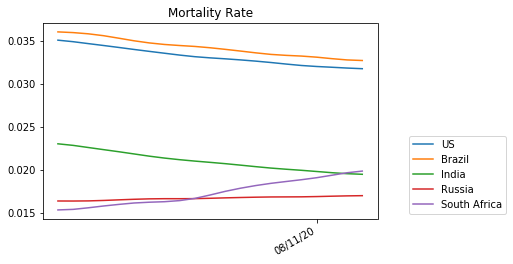

In [88]:
plt = plotn(dates, mort, 1, 5, title='Mortality Rate', date_range=[-22,-1])

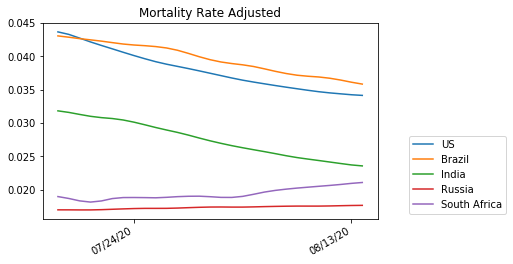

In [90]:
plt = plotn(dates, mort2, 1, 5, title='Mortality Rate Adjusted', date_range=[-30,-1])

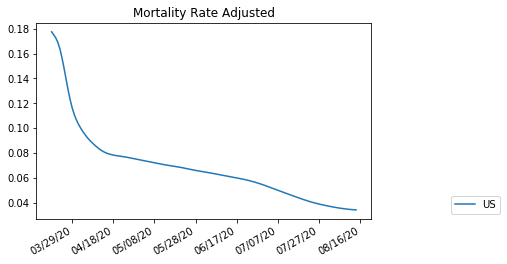

In [83]:
plt = plotc(dates=dates, df=mort2, filter_strength=3, countries=['US'], title='Mortality Rate Adjusted', date_range=[-150,-1])

In [50]:
create_json(conf_combined, 'confirmed')

In [43]:
test = conf_combined.drop(['Country/Region', 'Lat', 'Long'], axis=1)
len(list(test.iloc[0,:]))

64

In [46]:
len(growth(list(test.iloc[0,:]), dx=1))

64

In [44]:
len(test.index)

174

In [42]:
test.iloc[0,:] = growth(list(test.iloc[0,:]), dx=1)